### This notebook demonstrates how to use unfolding with the RooUnfoldOmnifold class
#### There are two main purposes for this class -- binned unfolding and unbinned unfolding
#### Binned unfolding takes the same input as the other RooUnfold classes and returns an unfolded histogram
#### Unbinned unfoldings instead uses lists of data. To make this work with ROOT, we use RDataFrames
#### In this notebook, we'll first generate the data, then do binned unfolding, and finally do unbinned unfolding

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt

### We'll now generate the data. This follows the generation from [the RooUnfold tutorial](https://statisticalmethods.web.cern.ch/StatisticalMethods/unfolding/RooUnfold_01-Methods/).

In [2]:
def smear(xt):
  xeff = 0.3 + (1.0-0.3)/20*(xt+10.0)  #  efficiency                                                                                  
  x = ROOT.gRandom.Rndm()
  if x>xeff: return None
  xsmear = ROOT.gRandom.Gaus(-2.5,0.2)     #  bias and smear 
  return xt + xsmear

In [3]:
# Number of data points we'll generate
num_MC_data = 100000
num_truth_data = 10000

# Defining the binning we'll use
MCreco_bins, MCreco_low, MCreco_high  = 40, -10, 10
MCgen_bins, MCgen_low, MCgen_high = 40, -10, 10
truth_bins, truth_low, truth_high = 40, -10, 10
measured_bins, measured_low, measured_high = 40, -10, 10

# Setting up our histograms and response matrix
MCgen_hist    = ROOT.TH1D("MCgen_hist", "MCgen_hist", MCgen_bins, MCgen_low, MCgen_high)
MCreco_hist   = ROOT.TH1D("MCreco_hist", "MCreco_hist", MCreco_bins, MCreco_low, MCreco_high)
response      = ROOT.RooUnfoldResponse(MCreco_bins, MCreco_low, MCreco_high, MCgen_bins, MCgen_low, MCgen_high)
truth_hist    = ROOT.TH1D ("truth_hist", "truth_hist", truth_bins, truth_low, truth_high)
measured_hist = ROOT.TH1D ("measured_hist", "measured_hist", measured_bins, measured_low, measured_high)

# These lists will contain the unbinned data, i.e. the data without being put into a histogram
unbinned_MCgen = []
unbinned_MCreco = []
unbinned_truth = []
unbinned_measured = []
MC_pass_reco = []
MC_pass_gen = []
measured_pass_reco = []

### Creating unbinned data

In [4]:
# Generating pseudodata
# For readability, we'll populate the unbinned entries and bin them afterwards

# Generating MC data
for i in range(num_MC_data):
    xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
    unbinned_MCgen.append(xt)
        
    # To demonstrate cuts on the true MC data, we'll make a cut on whether the data falls within the histogram bin range
    if xt < MCgen_low or xt > MCgen_high:
        MC_pass_gen.append(False)
    else:
        MC_pass_gen.append(True)

    # Smearing the MC data to imitate reconstruction
    x = smear(xt)
    if x != None:
        unbinned_MCreco.append(x)
        MC_pass_reco.append(True)
    else:
        # Note that the unbinned data should have the same length for the MC truth and MC reco (sim) data
        # So for events that don't pass reconstruction, a placeholder value should be used
        unbinned_MCreco.append(-9999)
        MC_pass_reco.append(False)

# Generating truth/measured data
for i in range(num_truth_data):
    xt = ROOT.gRandom.Gaus (0.0, 2.0)
    unbinned_truth.append(xt)
    
    x = smear(xt)
    if x != None:
        unbinned_measured.append(x)
        measured_pass_reco.append(True)
    else:
        unbinned_measured.append(-9999)
        measured_pass_reco.append(False)
        
# We'll now convert these to numpy arrays, which will act as input to the unbinned unfolding functions
unbinned_MCgen = np.array(unbinned_MCgen, dtype = np.float32)
unbinned_MCreco = np.array(unbinned_MCreco, dtype = np.float32)
unbinned_truth = np.array(unbinned_truth, dtype = np.float32)
unbinned_measured = np.array(unbinned_measured, dtype = np.float32)
MC_pass_reco = np.array(MC_pass_reco, dtype=bool)
MC_pass_gen = np.array(MC_pass_gen, dtype=bool)
measured_pass_reco = np.array(measured_pass_reco, dtype=bool)

### Binning the unbinned data

In [5]:
for (MCgen, MCreco, pass_reco) in zip(unbinned_MCgen, unbinned_MCreco, MC_pass_reco):
    MCgen_hist.Fill(MCgen)
    if pass_reco:
        response.Fill(MCreco, MCgen)
        MCreco_hist.Fill(MCreco)
    else:
        response.Miss(MCgen)
for (truth, measured, pass_reco) in zip(unbinned_truth, unbinned_measured, measured_pass_reco):
    truth_hist.Fill(truth)
    if pass_reco:
        measured_hist.Fill(measured)

### Visualize our distributions and response matrix

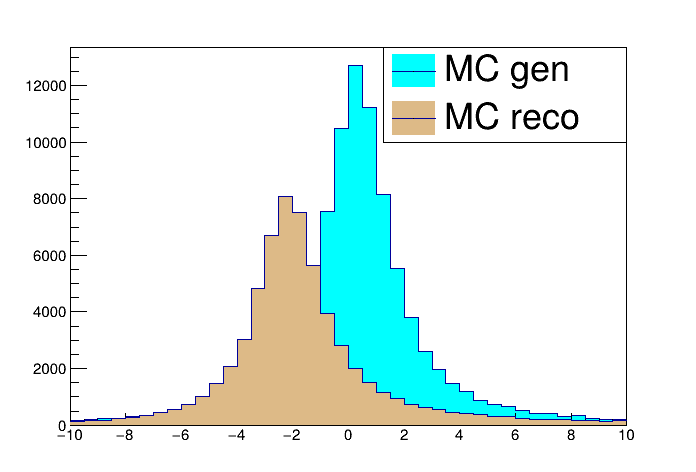

In [6]:
c = ROOT.TCanvas()
MCgen_hist.SetStats(0)
MCgen_hist.SetTitle("")
MCgen_hist.SetFillColor(7)
MCgen_hist.Draw()
MCreco_hist.SetFillColor(42)
MCreco_hist.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(MCgen_hist,"MC gen")
leg.AddEntry(MCreco_hist,"MC reco")
leg.Draw()
c.Draw()

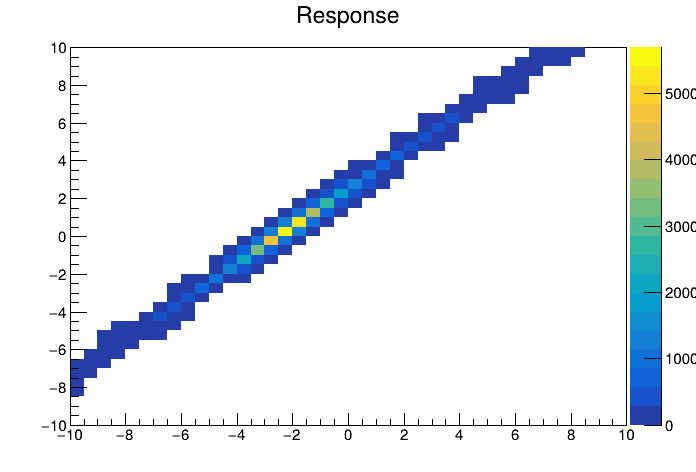

In [7]:
R = response.HresponseNoOverflow()
c1 = ROOT.TCanvas()
R.SetStats(0)
R.Draw("colz")
c1.Draw()

### Doing binned unfolding
#### Just like the other RooUnfold functions, this uses the response matrix and measured histogram
#### The bins of the returned histogram will be the same as the MC gen binning

In [8]:
num_iterations = 4
binned_unfolding = ROOT.RooUnfoldOmnifold(response, measured_hist, num_iterations)
binned_unfolding_hist = binned_unfolding.Hunfold()

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


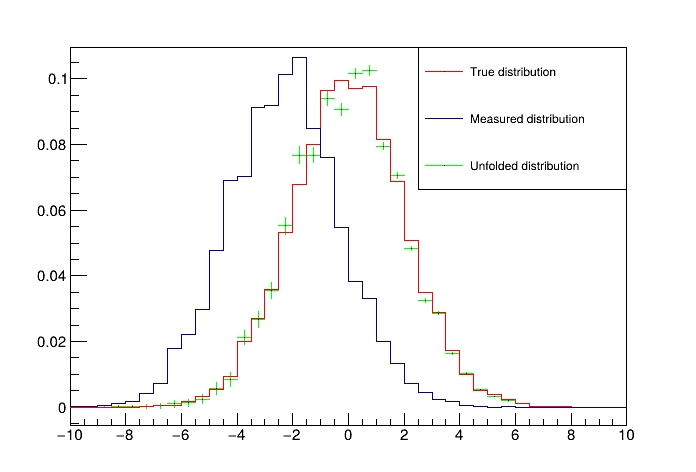

In [9]:
c_binned_unfolding = ROOT.TCanvas()
binned_unfolding_hist.SetStats(0)
binned_unfolding_hist.SetTitle("")
binned_unfolding_hist.SetLineColor(3)
truth_hist.SetLineColor(2)

binned_unfolding_hist.Draw()
truth_hist.Draw("same hist")
measured_hist.Draw("same hist")

#Normalizing the histograms
truth_hist.Scale(1/truth_hist.Integral())
measured_hist.Scale(1/measured_hist.Integral())
binned_unfolding_hist.Scale(1/binned_unfolding_hist.Integral())
leg_binned_unfolding = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg_binned_unfolding.AddEntry(truth_hist, "True distribution","pl")
leg_binned_unfolding.AddEntry(measured_hist, "Measured distribution", "pl")
leg_binned_unfolding.AddEntry(binned_unfolding_hist, "Unfolded distribution")
leg_binned_unfolding.Draw()
c_binned_unfolding.Draw()

### Doing unbinned unfolding
#### The first step is to get our numpy arrays into ROOT objects
#### The data entries should be converted to RDataFrames, while the boolean arrays should be converted to TVectors

In [10]:
df_MCgen = ROOT.RDF.FromNumpy({'unbinned_MCgen': unbinned_MCgen})
df_MCreco = ROOT.RDF.FromNumpy({'unbinned_MCreco': unbinned_MCreco})
df_measured = ROOT.RDF.FromNumpy({'unbinned_measured': unbinned_measured})

In [11]:
def np_to_TVector(array):
    vector = ROOT.TVector(len(array))
    for i, entry in enumerate(array):
        vector[i] = entry
    return vector

In [12]:
MC_pass_reco_vector = np_to_TVector(MC_pass_reco)
MC_pass_gen_vector = np_to_TVector(MC_pass_gen)
measured_pass_reco_vector = np_to_TVector(measured_pass_reco)

In [13]:
unbinned_unfolding = ROOT.RooUnfoldOmnifold()
unbinned_unfolding.SetMCDataFrame(df_MCgen)
unbinned_unfolding.SetSimDataFrame(df_MCreco)
unbinned_unfolding.SetMeasuredDataFrame(df_measured)
unbinned_unfolding.SetMCPassReco(MC_pass_reco_vector)
unbinned_unfolding.SetMCPassTruth(MC_pass_gen_vector)
unbinned_unfolding.SetMeasuredPassReco(measured_pass_reco_vector)
unbinned_unfolding.SetNumIterations(4)

In [14]:
unbinned_results = unbinned_unfolding.UnbinnedOmnifold()
step1_weights_TVector = ROOT.std.get[0](unbinned_results)
step2_weights_TVector = ROOT.std.get[1](unbinned_results)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


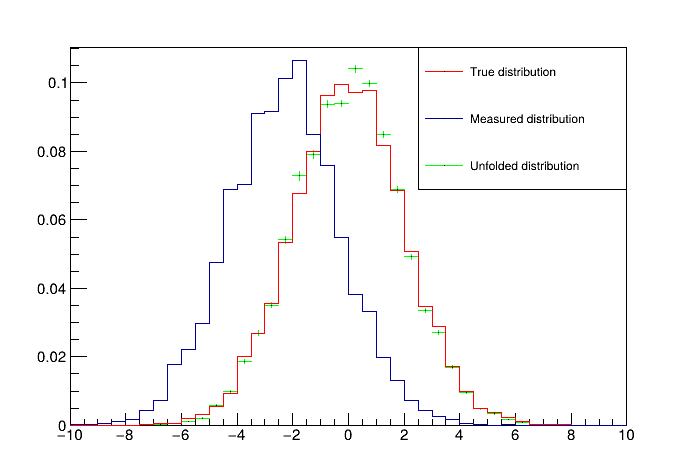

In [15]:
# Filling a histogram for plotting
unbinned_unfolding_hist = ROOT.TH1D("unbinned_unfolding_hist", "unbinned_unfolding_hist", MCgen_bins, MCgen_low, MCgen_high)
for i in range(step2_weights_TVector.GetNoElements()):
    unbinned_unfolding_hist.Fill(unbinned_MCgen[MC_pass_gen][i], step2_weights_TVector[i])
unbinned_unfolding_hist.Scale(1/unbinned_unfolding_hist.Integral())

c_unbinned_unfolding = ROOT.TCanvas()
unbinned_unfolding_hist.SetStats(0)
unbinned_unfolding_hist.SetTitle("")
unbinned_unfolding_hist.SetLineColor(3)
truth_hist.SetLineColor(2)

unbinned_unfolding_hist.Draw()
truth_hist.Draw("same hist")
measured_hist.Draw("same hist")

leg_unbinned_unfolding = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg_unbinned_unfolding.AddEntry(truth_hist, "True distribution","pl")
leg_unbinned_unfolding.AddEntry(measured_hist, "Measured distribution", "pl")
leg_unbinned_unfolding.AddEntry(unbinned_unfolding_hist, "Unfolded distribution")
leg_unbinned_unfolding.Draw()
c_unbinned_unfolding.Draw()

#### With this class, there's boosted decision trees under the hood
#### We can control the parameters of these decision trees using TMaps
#### The available parameters are found in the scikit-learn pages for [GradientBoostingClassifier](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) and [GradientBoostingRegressor](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html).
#### We'll adjust the n_estimators parameter

In [16]:
# There are 3 boosted decision trees used in this class
# A tree (GradientBoostingClassifier) for step 1 classification, a tree (GradientBoostingClassifier) for step 2 classification
# And a final tree (GradientBoostingRegressor) for handling events that don't pass reconstruction
step1classifier_params = ROOT.TMap()
step1classifier_params.Add(ROOT.TObjString("n_estimators"), ROOT.TObjString("50"))
step2classifier_params = ROOT.TMap()
step2classifier_params.Add(ROOT.TObjString("n_estimators"), ROOT.TObjString("50"))
step1regressor_params = ROOT.TMap()
step1regressor_params.Add(ROOT.TObjString("n_estimators"), ROOT.TObjString("50"))

# Setting the parameters
unbinned_unfolding.SetStep1ClassifierParameters(step1classifier_params)
unbinned_unfolding.SetStep2ClassifierParameters(step2classifier_params)
unbinned_unfolding.SetStep1RegressorParameters(step1regressor_params)

# Unfolding can now be run again with these parameters
unbinned_results_nestimators = unbinned_unfolding.UnbinnedOmnifold()
step1_weights_nestimators_TVector = ROOT.std.get[0](unbinned_results_nestimators)
step2_weights_nestimators_TVector = ROOT.std.get[1](unbinned_results_nestimators)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


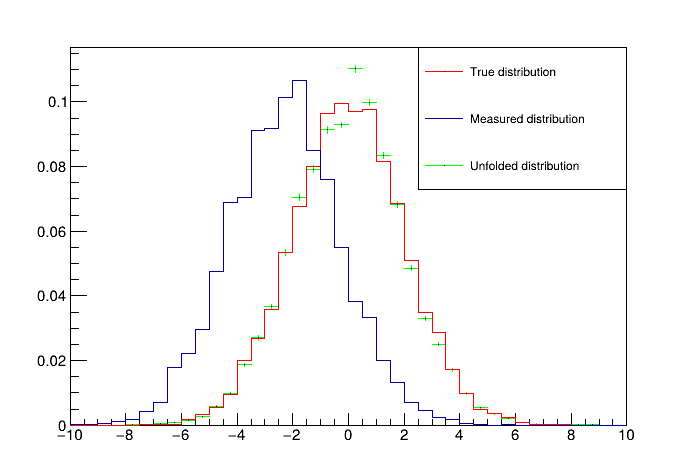

In [17]:
# Filling a histogram for plotting
unbinned_unfolding_hist_nestimators = ROOT.TH1D("unbinned_unfolding_hist_nestimators", "unbinned_unfolding_hist_nestimators", MCgen_bins, MCgen_low, MCgen_high)
for i in range(step2_weights_nestimators_TVector.GetNoElements()):
    unbinned_unfolding_hist_nestimators.Fill(unbinned_MCgen[MC_pass_gen][i], step2_weights_nestimators_TVector[i])
unbinned_unfolding_hist_nestimators.Scale(1/unbinned_unfolding_hist_nestimators.Integral())

c_unbinned_unfolding_nestimators = ROOT.TCanvas()
unbinned_unfolding_hist_nestimators.SetStats(0)
unbinned_unfolding_hist_nestimators.SetTitle("")
unbinned_unfolding_hist_nestimators.SetLineColor(3)
truth_hist.SetLineColor(2)

unbinned_unfolding_hist_nestimators.Draw()
truth_hist.Draw("same hist")
measured_hist.Draw("same hist")

leg_unbinned_unfolding_nestimators = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg_unbinned_unfolding_nestimators.AddEntry(truth_hist, "True distribution","pl")
leg_unbinned_unfolding_nestimators.AddEntry(measured_hist, "Measured distribution", "pl")
leg_unbinned_unfolding_nestimators.AddEntry(unbinned_unfolding_hist_nestimators, "Unfolded distribution")
leg_unbinned_unfolding_nestimators.Draw()
c_unbinned_unfolding_nestimators.Draw()

#### The trained boosted decision trees for unbinned unfolding are saved by default
#### After training, these trained models can be loaded and then be used to make predictions on a new dataset

In [18]:
unbinned_unfolding.SetModelSaving(True) # Can be set to False to not save the models
unbinned_unfolding.SetSaveDirectory("./") # "./" is the default
unbinned_unfolding.SetModelName("unbinned_unfolding_example") # The models will be saved in "./unbinned_unfolding_example_models.pkl"

#### To demonstrate loading the model and making new predictions, we'll split our MC dataset in half -- one half for training and the other half for predictions

In [19]:
num_split_data = int(num_MC_data/2)
unbinned_MCgen_train = unbinned_MCgen[:num_split_data]
unbinned_MCreco_train = unbinned_MCreco[:num_split_data]
MC_pass_reco_train = MC_pass_reco[:num_split_data]
MC_pass_gen_train = MC_pass_gen[:num_split_data]

df_MCgen_train = ROOT.RDF.FromNumpy({'unbinned_MCgen_train': unbinned_MCgen_train})
df_MCreco_train = ROOT.RDF.FromNumpy({'unbinned_MCreco_train': unbinned_MCreco_train})
MC_pass_reco_train_vector = np_to_TVector(MC_pass_reco_train)
MC_pass_gen_train_vector = np_to_TVector(MC_pass_gen_train)

unbinned_MCgen_test = unbinned_MCgen[num_split_data:]
unbinned_MCreco_test = unbinned_MCreco[num_split_data:]
MC_pass_reco_test = MC_pass_reco[num_split_data:]
MC_pass_gen_test = MC_pass_gen[num_split_data:]

# During training, the events that don't pass gen are removed. So during testing, we'll remove these events beforehand
unbinned_MCgen_test = unbinned_MCgen_test[MC_pass_gen_test]
unbinned_MCreco_test = unbinned_MCreco_test[MC_pass_gen_test]
MC_pass_reco_test = MC_pass_reco_test[MC_pass_gen_test]

df_MCgen_test = ROOT.RDF.FromNumpy({'unbinned_MCgen_test': unbinned_MCgen_test})
df_MCreco_test = ROOT.RDF.FromNumpy({'unbinned_MCreco_test': unbinned_MCreco_test})
MC_pass_reco_test_vector = np_to_TVector(MC_pass_reco_test)

In [20]:
unbinned_unfolding.SetMCDataFrame(df_MCgen_train)
unbinned_unfolding.SetSimDataFrame(df_MCreco_train)
unbinned_unfolding.SetMeasuredDataFrame(df_measured)
unbinned_unfolding.SetMCPassReco(MC_pass_reco_train_vector)
unbinned_unfolding.SetMCPassTruth(MC_pass_gen_train_vector)
unbinned_unfolding.SetMeasuredPassReco(measured_pass_reco_vector)
unbinned_unfolding.SetNumIterations(4)
train_weights = unbinned_unfolding.UnbinnedOmnifold()

print("Performing predictions")
unbinned_unfolding.SetTestMCDataFrame(df_MCgen_test)
unbinned_unfolding.SetTestSimDataFrame(df_MCreco_test)
unbinned_unfolding.SetTestMCPassReco(MC_pass_reco_test_vector)
test_unbinned_results = unbinned_unfolding.TestUnbinnedOmnifold()
step1_test_weights_TVector = ROOT.std.get[0](test_unbinned_results)
step2_test_weights_TVector = ROOT.std.get[1](test_unbinned_results)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3
Performing predictions


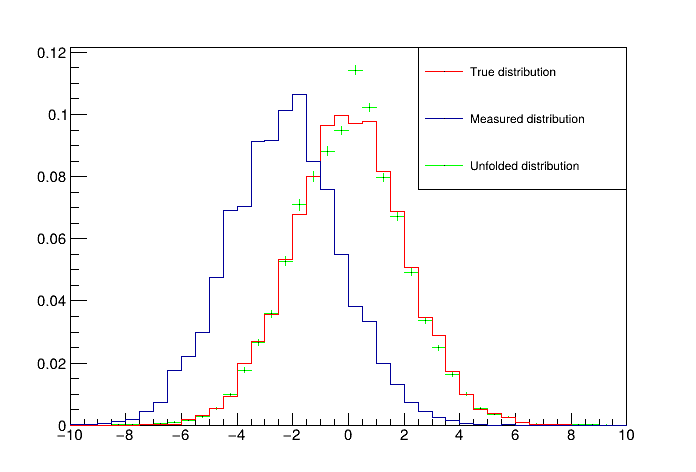

In [21]:
# Filling a histogram for plotting
unbinned_unfolding_hist_test = ROOT.TH1D("unbinned_unfolding_hist_test", "unbinned_unfolding_hist_test", MCgen_bins, MCgen_low, MCgen_high)
for i in range(step2_test_weights_TVector.GetNoElements()):
    unbinned_unfolding_hist_test.Fill(unbinned_MCgen_test[i], step2_test_weights_TVector[i])

c_unbinned_unfolding_test = ROOT.TCanvas()
unbinned_unfolding_hist_test.SetStats(0)
unbinned_unfolding_hist_test.SetTitle("")
unbinned_unfolding_hist_test.SetLineColor(3)
truth_hist.SetLineColor(2)

unbinned_unfolding_hist_test.Scale(1/unbinned_unfolding_hist_test.Integral())

unbinned_unfolding_hist_test.Draw()
truth_hist.Draw("same hist")
measured_hist.Draw("same hist")

leg_unbinned_unfolding_test = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg_unbinned_unfolding_test.AddEntry(truth_hist, "True distribution","pl")
leg_unbinned_unfolding_test.AddEntry(measured_hist, "Measured distribution", "pl")
leg_unbinned_unfolding_test.AddEntry(unbinned_unfolding_hist_test, "Unfolded distribution")
leg_unbinned_unfolding_test.Draw()
c_unbinned_unfolding_test.Draw()

#### Although not used in this notebook, the step 1 weights can be applied to the MCreco data to match the measured distribution.
#### These weights should be used from the first iteration of unfolding